In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '/home/hyunsu/Documents/data/cifar10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3) 

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape # since there were no padding. 30 x 30

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

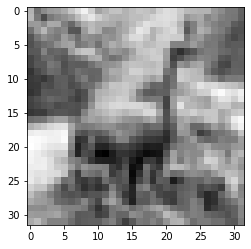

In [14]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

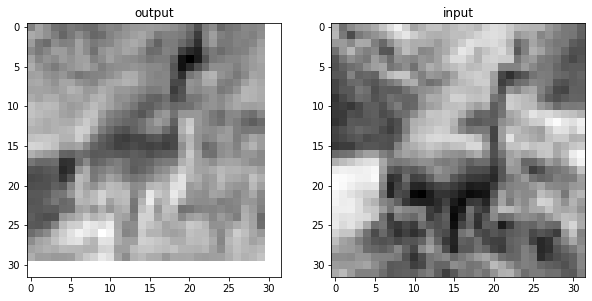

In [15]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
#plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # padding! ((kernel_width - 1)/2) if kernel size is odd number. 
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [17]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
conv.weight[0,0]

tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]], grad_fn=<SelectBackward0>)

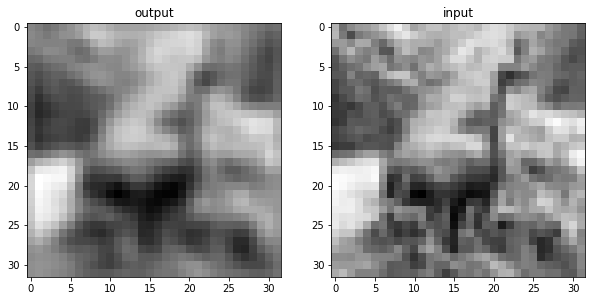

In [18]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
#plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]]) # vertical edge detector
    conv.bias.zero_()

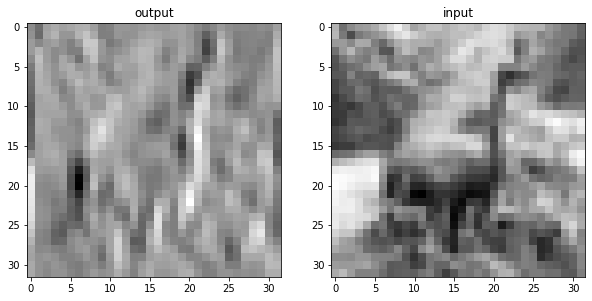

In [20]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
#plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [21]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [22]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),# ... something missed(flatten)
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [24]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
model(img.unsqueeze(0)) # expected error, if nn.Flatten() missed.

tensor([[ 0.2243, -0.2227]], grad_fn=<AddmmBackward0>)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # -1 is dimension of batch, because model doesn't know the number of batch
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list # number of weght parameter of each layer, for example first conv 3*16*3*3 = 432

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # tanh and max_poo2d has no parameter, thus
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # it's convinient not to set as submodule like above
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list 

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [30]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1309, -0.1730]], grad_fn=<AddmmBackward0>)

In [31]:

import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # batch will be get from train loader
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # method of using dataloader

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
) # 3~4sec per 10 epoch

2022-08-11 08:43:38.551965 Epoch 1, Training loss 0.6204581492266078
2022-08-11 08:43:51.352117 Epoch 10, Training loss 0.34094917024396787
2022-08-11 08:44:05.208732 Epoch 20, Training loss 0.30159388444605906
2022-08-11 08:44:18.993336 Epoch 30, Training loss 0.2755677341275914
2022-08-11 08:44:32.766409 Epoch 40, Training loss 0.2556727314071291
2022-08-11 08:44:48.934370 Epoch 50, Training loss 0.23590927006332738
2022-08-11 08:45:03.244258 Epoch 60, Training loss 0.2203263223266146
2022-08-11 08:45:17.046737 Epoch 70, Training loss 0.20421850993327653
2022-08-11 08:45:30.708592 Epoch 80, Training loss 0.190600866107804
2022-08-11 08:45:44.381291 Epoch 90, Training loss 0.1762493032795988
2022-08-11 08:45:58.123742 Epoch 100, Training loss 0.16387212319169076


In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.90


In [34]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt') # this will save just parameter, not architecture of model

In [35]:
loaded_model = Net()  # if you correctly load the architecture of model
loaded_model.load_state_dict(torch.load(data_path # this will successfully load the saved paramter
                                        + 'birds_vs_airplanes.pt')) 

<All keys matched successfully>

In [36]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [37]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # data to GPU
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
) # on GPU, 2-3 sec per 10 epoch

2022-08-11 08:46:01.323888 Epoch 1, Training loss 0.6064608955079582
2022-08-11 08:46:03.385557 Epoch 10, Training loss 0.33065343472608333
2022-08-11 08:46:05.655227 Epoch 20, Training loss 0.2923709557504411
2022-08-11 08:46:07.961317 Epoch 30, Training loss 0.2679338501232445
2022-08-11 08:46:10.250136 Epoch 40, Training loss 0.24255526118027937
2022-08-11 08:46:12.507629 Epoch 50, Training loss 0.22403830076289025
2022-08-11 08:46:14.759140 Epoch 60, Training loss 0.20990738424525898
2022-08-11 08:46:17.056790 Epoch 70, Training loss 0.19375898470734335
2022-08-11 08:46:19.380132 Epoch 80, Training loss 0.18062227029519476
2022-08-11 08:46:21.673317 Epoch 90, Training loss 0.16812750908314802
2022-08-11 08:46:23.967215 Epoch 100, Training loss 0.15466068257951432


In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [40]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device)) # saved parameters will be loaded to current device from anywhere saved

<All keys matched successfully>

In [41]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 3 -> 32 channel, wide width network
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-08-11 08:46:24.814702 Epoch 1, Training loss 0.5435322490847034
2022-08-11 08:46:27.054093 Epoch 10, Training loss 0.3199591824583187
2022-08-11 08:46:29.543892 Epoch 20, Training loss 0.27797868534637865
2022-08-11 08:46:32.036823 Epoch 30, Training loss 0.24682048546850302
2022-08-11 08:46:34.511997 Epoch 40, Training loss 0.2194809083156525
2022-08-11 08:46:36.989921 Epoch 50, Training loss 0.19394874658174577
2022-08-11 08:46:39.472633 Epoch 60, Training loss 0.17095293398875339
2022-08-11 08:46:42.153820 Epoch 70, Training loss 0.14996209864024143
2022-08-11 08:46:44.817571 Epoch 80, Training loss 0.13000939641693596
2022-08-11 08:46:47.461130 Epoch 90, Training loss 0.11161586539048678
2022-08-11 08:46:50.161722 Epoch 100, Training loss 0.09491392190621536
Accuracy train: 0.95
Accuracy val: 0.90


{'train': 0.9521, 'val': 0.9005}

In [62]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32): # you can handle the number of channel of 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = torch.flatten(out, 1) #out.view(-1, 8 * 8 * self.n_chans1 // 2) # you can simplify this by using flatten
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [63]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-08-11 10:10:03.244808 Epoch 1, Training loss 0.5577010888202935
2022-08-11 10:10:05.481963 Epoch 10, Training loss 0.32288934318882645
2022-08-11 10:10:07.940043 Epoch 20, Training loss 0.28186289206811577
2022-08-11 10:10:10.479326 Epoch 30, Training loss 0.2509319684972429
2022-08-11 10:10:12.996565 Epoch 40, Training loss 0.22084194478715302
2022-08-11 10:10:15.516406 Epoch 50, Training loss 0.193494333298343
2022-08-11 10:10:18.075654 Epoch 60, Training loss 0.1691637617672325
2022-08-11 10:10:20.629815 Epoch 70, Training loss 0.14657539983463894
2022-08-11 10:10:23.151690 Epoch 80, Training loss 0.12544177240057355
2022-08-11 10:10:25.678581 Epoch 90, Training loss 0.1059707979060662
2022-08-11 10:10:28.211120 Epoch 100, Training loss 0.0883176186875363
Accuracy train: 0.96
Accuracy val: 0.88


In [64]:
sum(p.numel() for p in model.parameters())

38386

In [46]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # definition of L2 regularization loss
            loss = loss + l2_lambda * l2_norm # here you can define customized loss function 

            optimizer.zero_grad()
            loss.backward() # pytorch handle customized loss fucntion by backward method
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [47]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-08-11 08:47:16.523041 Epoch 1, Training loss 0.5791277255222296
2022-08-11 08:47:20.341199 Epoch 10, Training loss 0.35909494748161097
2022-08-11 08:47:23.813987 Epoch 20, Training loss 0.3215523775026297
2022-08-11 08:47:27.162469 Epoch 30, Training loss 0.3018977906863401
2022-08-11 08:47:30.246631 Epoch 40, Training loss 0.285498607215608
2022-08-11 08:47:33.334855 Epoch 50, Training loss 0.2718802682913033
2022-08-11 08:47:36.466517 Epoch 60, Training loss 0.26006762987109505
2022-08-11 08:47:39.752305 Epoch 70, Training loss 0.24906921529086531
2022-08-11 08:47:43.035379 Epoch 80, Training loss 0.23843149404237224
2022-08-11 08:47:46.320454 Epoch 90, Training loss 0.22811628004927545
2022-08-11 08:47:49.605566 Epoch 100, Training loss 0.21813951408976961
Accuracy train: 0.92
Accuracy val: 0.89


In [48]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4) # you can define the probability of drop out. 
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4) 
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [49]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-08-11 08:47:50.251479 Epoch 1, Training loss 0.5702674003543368
2022-08-11 08:47:52.696187 Epoch 10, Training loss 0.3789597290336706
2022-08-11 08:47:55.414499 Epoch 20, Training loss 0.3540128643155857
2022-08-11 08:47:58.118614 Epoch 30, Training loss 0.3259592861126942
2022-08-11 08:48:00.822572 Epoch 40, Training loss 0.3133743723296815
2022-08-11 08:48:03.519556 Epoch 50, Training loss 0.29937712468539074
2022-08-11 08:48:06.209219 Epoch 60, Training loss 0.28837746419724386
2022-08-11 08:48:08.898429 Epoch 70, Training loss 0.2803780650067481
2022-08-11 08:48:11.587071 Epoch 80, Training loss 0.2650473575303509
2022-08-11 08:48:14.306263 Epoch 90, Training loss 0.2589271822173125
2022-08-11 08:48:17.021063 Epoch 100, Training loss 0.24621064363011888
Accuracy train: 0.90
Accuracy val: 0.87


In [50]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-08-11 08:48:17.576210 Epoch 1, Training loss 0.4971518746227216
2022-08-11 08:48:20.342530 Epoch 10, Training loss 0.27425837165610806
2022-08-11 08:48:23.410646 Epoch 20, Training loss 0.21253386619174555
2022-08-11 08:48:26.489107 Epoch 30, Training loss 0.16669431604017879
2022-08-11 08:48:29.557046 Epoch 40, Training loss 0.12564205375921195
2022-08-11 08:48:32.632724 Epoch 50, Training loss 0.0907603711791479
2022-08-11 08:48:35.693026 Epoch 60, Training loss 0.06154538313769231
2022-08-11 08:48:38.749278 Epoch 70, Training loss 0.040030877829594594
2022-08-11 08:48:41.802967 Epoch 80, Training loss 0.030705907826970337
2022-08-11 08:48:44.857168 Epoch 90, Training loss 0.01926430673368133
2022-08-11 08:48:47.913147 Epoch 100, Training loss 0.014840060386771135
Accuracy train: 0.99
Accuracy val: 0.88


In [52]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-08-11 08:48:48.609813 Epoch 1, Training loss 0.6815542343315805
2022-08-11 08:48:51.176931 Epoch 10, Training loss 0.34762399847720077
2022-08-11 08:48:54.025161 Epoch 20, Training loss 0.3026832454143816
2022-08-11 08:48:56.874102 Epoch 30, Training loss 0.27354775131887693
2022-08-11 08:48:59.686431 Epoch 40, Training loss 0.2446387816861177
2022-08-11 08:49:02.672534 Epoch 50, Training loss 0.21581906920215885
2022-08-11 08:49:05.754971 Epoch 60, Training loss 0.18900177139005844
2022-08-11 08:49:08.813136 Epoch 70, Training loss 0.16310852478928628
2022-08-11 08:49:11.865603 Epoch 80, Training loss 0.13805219030399232
2022-08-11 08:49:14.995828 Epoch 90, Training loss 0.11425612831286563
2022-08-11 08:49:18.076500 Epoch 100, Training loss 0.09176883063498575
Accuracy train: 0.95
Accuracy val: 0.90


In [74]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out # skip connection, just skipped conv3 and relu 
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
print(NetRes())

NetRes(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [55]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-08-11 08:49:18.662918 Epoch 1, Training loss 0.616012452704132
2022-08-11 08:49:21.370960 Epoch 10, Training loss 0.3319622751823656
2022-08-11 08:49:24.256048 Epoch 20, Training loss 0.2916932509393449
2022-08-11 08:49:27.140216 Epoch 30, Training loss 0.25998148217702366
2022-08-11 08:49:30.023086 Epoch 40, Training loss 0.23041668861724768
2022-08-11 08:49:32.902294 Epoch 50, Training loss 0.20255851660184798
2022-08-11 08:49:35.807063 Epoch 60, Training loss 0.1753722433071987
2022-08-11 08:49:38.687293 Epoch 70, Training loss 0.14894376173140897
2022-08-11 08:49:41.565033 Epoch 80, Training loss 0.1242137712183272
2022-08-11 08:49:44.484606 Epoch 90, Training loss 0.09995534553364584
2022-08-11 08:49:47.530843 Epoch 100, Training loss 0.0768674688567971
Accuracy train: 0.96
Accuracy val: 0.90


In [56]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # if you use BatchNorm, bias used to be skipped
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x # here skipped connection occur # TODO from here

In [57]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [58]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-08-11 08:49:54.521398 Epoch 1, Training loss 2.710036470631885
2022-08-11 08:50:52.421068 Epoch 10, Training loss 0.3549676302132333
2022-08-11 08:51:56.783419 Epoch 20, Training loss 0.267847617577975
2022-08-11 08:53:00.946790 Epoch 30, Training loss 0.22099116662884974
2022-08-11 08:54:05.337081 Epoch 40, Training loss 0.18725650795515936
2022-08-11 08:55:09.623700 Epoch 50, Training loss 0.1530761026842579
2022-08-11 08:56:13.998238 Epoch 60, Training loss 0.13516617526009583
2022-08-11 08:57:18.239841 Epoch 70, Training loss 0.1087131552208381
2022-08-11 08:58:22.309287 Epoch 80, Training loss 0.09738433784004419
2022-08-11 08:59:26.388927 Epoch 90, Training loss 0.07545375896344898
2022-08-11 09:00:30.457426 Epoch 100, Training loss 0.07372183105937995
Accuracy train: 0.96
Accuracy val: 0.87


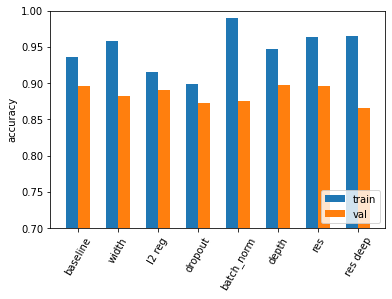

In [65]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
#plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()


In [66]:
def training_loop_l1reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l1_lambda = 0.001
            l1_norm = sum(torch.abs(p).sum()
                          for p in model.parameters())  # definition of L1 regularization loss
            loss = loss + l1_lambda * l1_norm # here you can define customized loss function 

            optimizer.zero_grad()
            loss.backward() # pytorch handle customized loss fucntion by backward method
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [68]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l1reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l1 reg"] = validate(model, train_loader, val_loader)

2022-08-11 10:27:48.580160 Epoch 1, Training loss 1.0204630672552024
2022-08-11 10:27:51.360472 Epoch 10, Training loss 0.6197127994078739
2022-08-11 10:27:54.343573 Epoch 20, Training loss 0.4779412537623363
2022-08-11 10:27:57.411435 Epoch 30, Training loss 0.42996623618587565
2022-08-11 10:28:00.710908 Epoch 40, Training loss 0.40997534705575106
2022-08-11 10:28:03.795692 Epoch 50, Training loss 0.3961164785228717
2022-08-11 10:28:06.861744 Epoch 60, Training loss 0.3858772499166476
2022-08-11 10:28:10.010647 Epoch 70, Training loss 0.3780382421745616
2022-08-11 10:28:13.072490 Epoch 80, Training loss 0.3716689235275718
2022-08-11 10:28:16.195322 Epoch 90, Training loss 0.36609586333013644
2022-08-11 10:28:19.280474 Epoch 100, Training loss 0.361215170686412
Accuracy train: 0.88
Accuracy val: 0.87


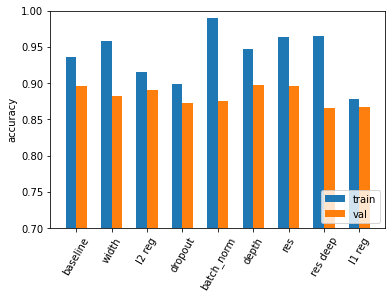

In [69]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
#plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()